In [1]:
import os 
import boto3
import io
import sagemaker

%matplotlib inline

import pandas as pd
import numpy as np
!pip install mxnet
import mxnet as mx
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pickle, gzip, urllib, json
import csv
from sagemaker import get_execution_role
role = get_execution_role()
s3 = boto3.resource('s3')


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.6 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
#Load Data
bucket_name = 'sg-ml-bucket-02'
object_key = 'Absenteeism_at_work.csv'
s3_client = boto3.client('s3')
response = s3_client.get_object(Bucket=bucket_name, Key=object_key)
response_body = response["Body"].read()
absence = pd.read_csv(io.BytesIO(response_body), header=0, delimiter=",", low_memory=False)
absence.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,2


In [3]:
# Drop the ID Column
absence = absence.drop(['ID'], axis=1)

In [4]:
absence.shape

(740, 20)

In [5]:
#EDA Drop any missing values obs
absence.dropna(inplace=True)
absence.shape

(740, 20)

In [6]:
# Set ''Reason for absence' as index
# rest of numerical features become attributes of each unique absence
absence.index=absence['Reason for absence']
absence.head()

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
Reason for absence,,,,,,,,,,,,,,,,,,,,
26,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
0,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
23,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
7,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
23,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


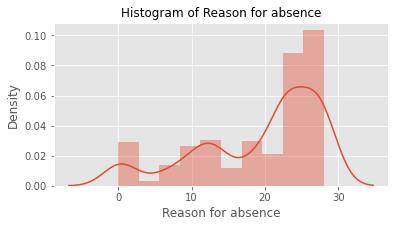

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


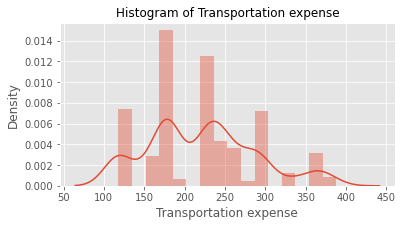

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


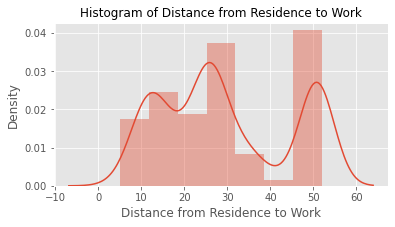

In [7]:
#Visualize data for some of our columns for distribution
import seaborn as sns

for a in ['Reason for absence', 'Transportation expense', 'Distance from Residence to Work']:
    ax = plt.subplots(figsize=(6,3))
    ax = sns.distplot(absence[a])
    title = "Histogram of " + a
    ax.set_title(title, fontsize=12)
    plt.show()

In [8]:
#Standardize the scaling of the columns in order to use any distance based analytical methods
# We can compare the relative distances between different feature columns
# MinMaxScaler to transform columns so they fall between 0 and 1

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
absence_scaled = pd.DataFrame(scaler.fit_transform(absence))
absence_scaled.columns = absence.columns
absence_scaled.index = absence.index

In [9]:
absence_scaled.describe()
# all columns have been scaled between 0 and 1

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,0.686293,0.527027,0.478716,0.514865,0.382703,0.524066,0.412645,0.304839,0.379108,0.715149,0.054054,0.097297,0.254730,0.567568,0.072973,0.093243,0.442983,0.276208,0.404054,0.057703
std,0.301193,0.286357,0.355419,0.370610,0.247971,0.315676,0.156603,0.208993,0.225813,0.198911,0.226277,0.224413,0.274622,0.495749,0.260268,0.164782,0.247754,0.182879,0.225550,0.111092
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.464286,0.250000,0.250000,0.333333,0.225926,0.234043,0.285714,0.129032,0.222412,0.631579,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.181818,0.263158,0.016667
50%,0.821429,0.500000,0.500000,0.666667,0.396296,0.446809,0.428571,0.322581,0.337244,0.736842,0.000000,0.000000,0.250000,1.000000,0.000000,0.000000,0.519231,0.212121,0.315789,0.025000
75%,0.928571,0.750000,0.750000,1.000000,0.525926,0.957447,0.535714,0.419355,0.510502,0.842105,0.000000,0.000000,0.500000,1.000000,0.000000,0.125000,0.634615,0.272727,0.631579,0.066667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
# PCA to reduce features to relevant
bucket = bucket_name
from sagemaker import PCA
num_components=19

pca_SM = PCA(role=role,
            train_instance_count=1,
            train_instance_type='ml.c4.xlarge',
            output_path='s3://' + bucket + '/absence/',
            num_components=num_components)


train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [11]:
# Extract the numpy array from the DF and cast to float32
train_data = absence_scaled.values.astype('float32')

In [13]:
# Train PCA on train set
%time
pca_SM.fit(pca_SM.record_set(train_data))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-09-23 16:46:49 Starting - Starting the training job...
2022-09-23 16:47:15 Starting - Preparing the instances for trainingProfilerReport-1663951609: InProgress
......
2022-09-23 16:48:17 Downloading - Downloading input data...
2022-09-23 16:48:38 Training - Downloading the training image.........
2022-09-23 16:50:14 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[09/23/2022 16:50:14 INFO 139758084417344] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[09/23/2022 16:50:14 INFO 139758084417344] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {'feature_dim': 


2022-09-23 16:50:35 Uploading - Uploading generated training model
2022-09-23 16:50:35 Completed - Training job completed
Training seconds: 138
Billable seconds: 138


In [14]:
#Store Model Artifacts in S3
job_name = pca_SM.latest_training_job.name
model_key = "absence/" + job_name + "/output/model.tar.gz"

boto3.resource('s3').Bucket(bucket).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')

model_algo-1


0

In [15]:
# Post model decompression, load the ND array using MXNet
import mxnet as mx
pca_model_params = mx.ndarray.load('model_algo-1')

In [16]:
# Extract explained-variance-ratio vector
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [17]:
#Calculate the variance explained by the largest n components that we want to keep.
# Take the top 5
# The largest 5 components explain ~62% of the total variance in the dataset
s.iloc[14:,:].apply(lambda x: x*x).sum()/s.apply(lambda x: x*x).sum()

0    0.622284
dtype: float32

In [18]:
# After keeping the top 5 components, take only the 5 largest components from original s and v matrix
s_5=s.iloc[14:,:]
v_5=v.iloc[:,14:]
v_5_columns=[0,1,2,3,4]

In [19]:
v_5.columns = range(v_5.columns.size)
v_5.head()

,0,1,2,3,4
0,0.407281,-0.448665,0.193074,0.289915,-0.059501
1,0.217295,-0.079499,-0.023497,-0.452234,-0.036570
2,-0.584830,-0.525670,0.547078,-0.047001,-0.035020
3,0.160280,-0.319543,-0.043324,-0.762302,0.045018
4,0.098019,0.332768,0.286093,-0.152991,-0.065728


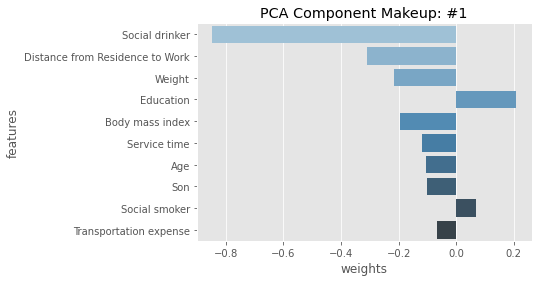

In [20]:
# Examine the makeup of one of the PCA components based on the weightings of the original features \n",
# that are included in the component\n",
# Understand what the key positive and negative attributes are for the component\n",
component_num=1
first_comp = v_5[5-component_num]
comps = pd.DataFrame(list(zip(first_comp, absence_scaled.columns)), columns=['weights', 'features'])
comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
ax=sns.barplot(data=comps.sort_values('abs_weights', ascending=False).head(10), x="weights", y="features", palette="Blues_d")
ax.set_title("PCA Component Makeup: #" + str(component_num))
plt.show()

In [21]:
%time
pca_predictor = pca_SM.deploy(initial_instance_count=1,
                             instance_type='ml.t2.medium')

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10.7 µs


Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-------------!

In [22]:
%time
result = pca_predictor.predict(train_data)



CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


In [23]:
# Create a dataset where each absenteeism is described by the 5 principle components,
PCA_list=['Social drinker', 'Distance from Residence to Work', 'Weight', 'Education', 'Body mass index']
absence_transformed=pd.DataFrame()
for a in result:
    b=a.label['projection'].float32_tensor.values
    absence_transformed=absence_transformed.append([list(b)])
absence_transformed.index=absence_scaled.index
absence_transformed=absence_transformed.iloc[:,14:]
absence_transformed.columns=PCA_list

In [24]:
absence_transformed.head()

,Social drinker,Distance from Residence to Work,Weight,Education,Body mass index
Reason for absence,,,,,
26,0.220163,0.277262,0.023891,0.416488,-0.574165
0,-0.813139,0.473745,-0.941796,0.071819,-0.446411
23,0.119235,-0.130268,-0.052720,0.539152,-0.643213
7,-0.839607,0.590692,0.207264,0.134280,-0.147293
23,-0.115692,0.061643,0.277216,0.362107,-0.585175


In [25]:
# Use the Kmeans algo to segment the absenteeism by the 5 PCA attributes we created.
train_data = absence_transformed.values.astype('float32')

In [26]:
# Find the top 7 clusters from our dataset\n",
from sagemaker import KMeans

num_clusters = 7
kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path='s3://'+ bucket +'/absence/',
                k=num_clusters)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [27]:
%time
kmeans.fit(kmeans.record_set(train_data))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-09-23 18:38:35 Starting - Starting the training job...
2022-09-23 18:39:03 Starting - Preparing the instances for trainingProfilerReport-1663958315: InProgress
.........
2022-09-23 18:40:19 Downloading - Downloading input data...
2022-09-23 18:40:59 Training - Downloading the training image......
2022-09-23 18:42:06 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[09/23/2022 18:42:10 INFO 139926763284288] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_


2022-09-23 18:42:21 Uploading - Uploading generated training model
2022-09-23 18:42:59 Completed - Training job completed
Training seconds: 148
Billable seconds: 148


In [28]:
%time 
kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs
-----------------!

In [32]:
%time
result=kmeans_predictor.predict(train_data)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


In [33]:
# Breakdonw of cluster counts and distribution of clusters
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


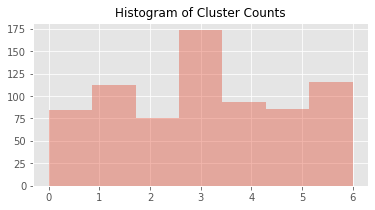

In [34]:
# Plot Clusters
ax = plt.subplots(figsize=(6,3))
ax = sns.distplot(cluster_labels, kde=False)
title = "Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

In [35]:
pd.DataFrame(cluster_labels)[0].value_counts()

3.0    173
6.0    116
1.0    112
4.0     93
5.0     86
0.0     84
2.0     76
Name: 0, dtype: int64

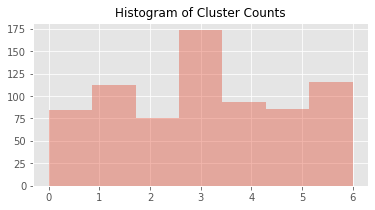

In [36]:
# Plot Clusters
ax = plt.subplots(figsize=(6,3))
ax = sns.distplot(cluster_labels, kde=False)
title = "Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

In [37]:
# Access the underlying model to get the cluster centers
# Centers will help describe which features characterize each cluster
# First retrieve the K-Means model attributes
job_name = kmeans.latest_training_job.name
model_key = "absence/" + job_name + "/output/model.tar.gz"
boto3.resource('s3').Bucket(bucket).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')

model_algo-1


0

In [38]:
Kmeans_model_params = mx.ndarray.load('model_algo-1')

In [39]:
# Cluster Centroid Locations: The location of the centers of each cluster identified by the Kmeans algorithm\n",
cluster_centroids=pd.DataFrame(Kmeans_model_params[0].asnumpy())
cluster_centroids.columns=absence_transformed.columns

In [40]:
cluster_centroids

,Social drinker,Distance from Residence to Work,Weight,Education,Body mass index
0,0.266565,-0.120151,0.117880,-0.510888,-0.483240
1,-0.147625,-0.127010,0.289609,0.163675,0.670386
2,-0.127036,0.585411,0.093807,-0.106866,-0.343433
3,0.033372,-0.051645,0.183680,0.309833,-0.536555
4,-0.339703,-0.098426,-0.469635,-0.030018,-0.414794
5,0.196376,-0.221730,-0.100847,-0.524822,0.578544
6,0.061798,0.169225,-0.229866,0.269877,0.626005


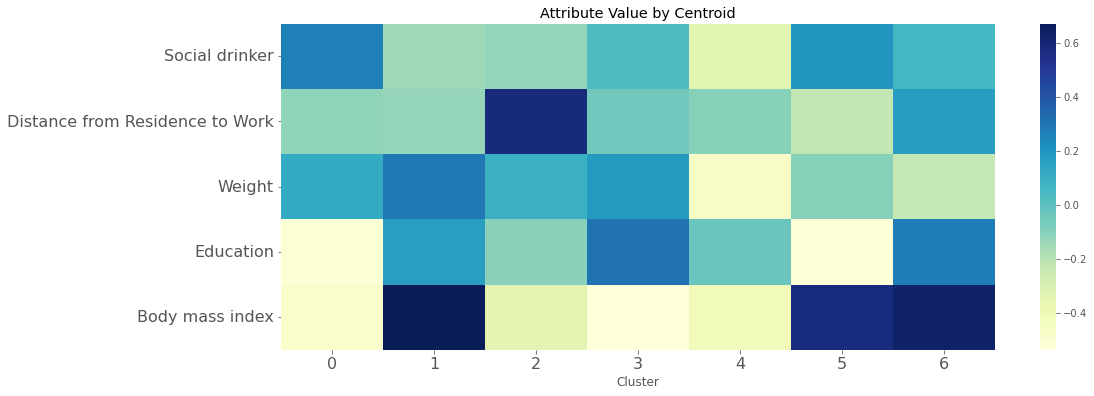

In [41]:
# Plot a heatmap of the centroids and their location in the transformed feature space\n",
plt.figure(figsize = (16, 6))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

In [42]:
# Dark Blue is a positive influence on absenteeism
# Map the cluster labels back to each individual absenteeism and examine which were naturally grouped together\n",
absence_transformed['labels']=list(map(int, cluster_labels))
absence_transformed.head()

,Social drinker,Distance from Residence to Work,Weight,Education,Body mass index,labels
Reason for absence,,,,,,
26,0.220163,0.277262,0.023891,0.416488,-0.574165,3
0,-0.813139,0.473745,-0.941796,0.071819,-0.446411,4
23,0.119235,-0.130268,-0.052720,0.539152,-0.643213,3
7,-0.839607,0.590692,0.207264,0.134280,-0.147293,2
23,-0.115692,0.061643,0.277216,0.362107,-0.585175,3


In [43]:
# Examine one of the clusters in more detail\n",
cluster=absence_transformed[absence_transformed['labels']==1]
cluster.head(5)

,Social drinker,Distance from Residence to Work,Weight,Education,Body mass index,labels
Reason for absence,,,,,,
11,-0.243330,0.173077,0.283201,0.288298,0.503087,1
18,-0.393459,0.127115,0.057678,0.302918,0.359213,1
23,-0.201301,-0.218218,-0.041926,0.398200,0.586990,1
28,-0.394209,-0.164540,0.263402,0.394709,0.329208,1
23,0.000691,-0.274872,0.497824,-0.040010,0.551605,1


In [44]:
# Delete the PCA endpoint\n",
sagemaker.Session().delete_endpoint(pca_predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [45]:
# Delete the Kmeans endpoint\n",
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
